In [2]:
import numpy as np
import h5py
import sys
sys.path.append('F:\Linux')
import illustris_python as il
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

def find_id(all_id):
    il1_id = np.zeros(len(all_id), dtype=int)
    for i in range(len(all_id)):
        il1_id[i] = -1
        for j in range(5):
            if all_id[i][j] != -1:
                il1_id[i] = all_id[i][j]
    return il1_id

def SubhaloMatch(tng_subID):
    '''
    return matched SubhaloID in il1.
    No match return -1
    '''
    tng_GID = Groups_tng[tng_subID]
    il1_GID = tng_to_il1[tng_GID]
    if il1_GID == -1:
        return il1_GID
    try:
        if len(il1_HaloToSubdisk[il1_GID]) == 1:
            return (il1_HaloToSubdisk[il1_GID])[0]
        il1_subIDs = il1_HaloToSubdisk[il1_GID]
    except KeyError:
        il1_subIDs = il1_GroupSubhalo[il1_GID]

    return SubPositionMatch(tng_subID, il1_subIDs)
    
def SubPositionMatch(tng_subID, il1_subIDs):
    '''
    If one dark matter halo has several center galaxies, match them by subhalo position.
    return a list of their distance
    '''
    mass = abs(tng_DMMass[tng_subID] - il1_DMMass[il1_subIDs])
    ind = np.where(mass == mass.min())[0][0]
    return il1_subIDs[ind]

def MatchedCentralGalaxy(tng_subID):
    '''
    return matched central galaxy in il1
    No match return -1
    '''
    tng_GID = Groups_tng[tng_subID]
    il1_GID = tng_to_il1[tng_GID]
    if il1_GID == -1:
        return il1_GID
    if isCentral(tng_subID):
        return il1_GFSub[il1_GID]
    else:
        return -1
    
def HistValAndBin(nums, bins):
    val = []
    tmp = nums[nums < bins[1]]
    val.append(len(tmp))

    for i in range(1,len(bins)-1):
        tmp = nums[(nums > bins[i]) & (nums <= bins[i+1])]
        val.append(len(tmp))
    return val

In [5]:
#match disk halo between TNG & illustris-1
tngdisk = np.load('f:/Linux/localRUN/diskID_4WP.npy')
il1disk = np.load('f:/Linux/localRUN/diskID_il1.npy')

tng_barred = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
il1_barred = np.load('f:/Linux/localRUN/barredID_il1.npy')

Groups_tng = il.func.loadSubhalos('TNG', 99, "SubhaloGrNr")
Groups_il1 = il.func.loadSubhalos('il1', 135, "SubhaloGrNr")

tng_diskGIDs = Groups_tng[tngdisk]
il1_diskGIDs = Groups_il1[il1disk]

tng_barredGID = Groups_tng[tng_barred]
il1_barredGID = Groups_il1[il1_barred]

#load TNG groups informations
cm_TNG = il.func.loadhalos('TNG', 99, 'GroupPos')
tng_subCM = il.func.loadSubhalos('TNG', 99, 'SubhaloCM')
mass_TNG = il.func.loadhalos('TNG', 99, 'GroupMassType')[:, 1]

#build illustris halo as a tree
cm_il1 = il.func.loadhalos('il1', 135, 'GroupPos')
il1_subCM = il.func.loadSubhalos('il1', 135, 'SubhaloCM')
mass_il1 = il.func.loadhalos('il1', 135, 'GroupMassType')[:, 1]

#Is centre galaxy
tng_GFSub = il.func.loadhalos('TNG', 99, 'GroupFirstSub')
il1_GFSub = il.func.loadhalos('il1', 135, 'GroupFirstSub')
def isCentral(haloID, simu='tng'):
    if simu == 'tng':
        GID = Groups_tng[haloID]
        GFSub = tng_GFSub[GID]
    else:
        GID = Groups_il1[haloID]
        GFSub = il1_GFSub[GID]
        
    if GFSub == haloID:
        return True
    else:
        return False

    
def findMatchSubhalo(haloID, simu='tng'):
    #input subhaloID in TNG, return matched subhaloID in il1
    GID = Groups_tng[haloID]
    try:
        il1_GID = tng_to_il1[GID]
    except:
        print('halo ', haloID,' no match.')
        return -1
    return il1_GFSub[il1_GID]
    

#SFR
tng_SFR = il.func.loadSubhalos('TNG', 99, "SubhaloSFRinHalfRad")
il1_SFR = il.func.loadSubhalos('il1', 135, "SubhaloSFRinHalfRad")

#DM mass
tng_DMMass = il.func.loadSubhalos('TNG', 99, "SubhaloMassInRadType")[:,1]
il1_DMMass = il.func.loadSubhalos('il1', 135, "SubhaloMassInRadType")[:,1]

#Stellar mass
tng_StellarMass = il.func.loadSubhalos('TNG', 99, "SubhaloMassInRadType")[:,4]
il1_StellarMass = il.func.loadSubhalos('il1', 135, "SubhaloMassInRadType")[:,4]

#Gas Fraction
tng_GasFraction = il.func.loadSubhalos('TNG', 99, "SubhaloMassInRadType")[:,0] / il.func.loadSubhalos('TNG', 99, "SubhaloMassInHalfRad")
il1_GasFraction = il.func.loadSubhalos('il1', 135, "SubhaloMassInRadType")[:,0] / il.func.loadSubhalos('il1', 135, "SubhaloMassInHalfRad")
tng_GasFraction[np.isnan(tng_GasFraction)] = 0
il1_GasFraction[np.isnan(il1_GasFraction)] = 0

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


In [3]:
tree = KDTree(cm_il1, leaf_size = 2)

In [5]:
#tngID, il1ID, dis, absMass
sameHalo = [[], [], [], []]
for groupID in np.unique(tng_diskGIDs):
    sameHalo[0].append([groupID])
    dis, index = tree.query(cm_TNG[groupID].reshape(1, -1), k=10)

    il1_id = []
    distance = []
    absMass = []
    for i in range(10):
        if abs(mass_TNG[groupID] - mass_il1[index[0, i]]) <= mass_TNG[groupID]*0.5:
            il1_id.append(index[0, i])
            distance.append(dis[0, i])
            absMass.append(abs(mass_TNG[groupID] - mass_il1[index[0, i]]))
        else:
            il1_id.append(-1)
            distance.append(dis[0, i])
            absMass.append(abs(mass_TNG[groupID] - mass_il1[index[0, i]]))

    sameHalo[1].append(il1_id)
    sameHalo[2].append(distance)
    sameHalo[3].append(absMass)

sameHalo = np.array(sameHalo)

NameError: name 'tree' is not defined

In [6]:
tng_to_il1 = np.load('f:/Linux/localRUN/tng_to_il1/tng_to_il1.npy',allow_pickle=True).item()
tng_bar_hostGID_matched = np.load('f:/Linux/localRUN/tng_to_il1/tng_bar_hostGID_matched.npy',allow_pickle=True)
tng_barred_matchedGID = np.load('f:/Linux/localRUN/tng_to_il1/tng_barred_matchedGID.npy',allow_pickle=True)
tng_disk_matchedGID = np.load('f:/Linux/localRUN/tng_to_il1/tng_disk_matchedGID.npy',allow_pickle=True)
tng_to_il1_matched_barred_centergalaxies = np.load('f:/Linux/localRUN/tng_to_il1/tng_to_il1_matched_barred_centergalaxies.npy',allow_pickle=True).item()
tng_barred_il1_nobarGID = np.load('f:/Linux/localRUN/tng_to_il1/tng_barred_il1_nobarGID.npy',allow_pickle=True)


#TNG disk subhalo match il1 subhalo
tng_matched_il1disk = {}
tng_matched_il1notdisk = {}

tng_bar_matched_il1bar = {}
tng_bar_matched_il1_nobardisk = {}
tng_bar_matched_il1_nobar_others = {}

for i in tngdisk:
    tmp = MatchedCentralGalaxy(i)
    if tmp != -1:
        if tmp in il1disk:
            tng_matched_il1disk[i] = tmp
        else:
            tng_matched_il1notdisk[i] = tmp

for i in tng_barred:
    tmp = MatchedCentralGalaxy(i)
    if tmp != -1:
        if tmp in il1_barred:
            tng_bar_matched_il1bar[i] = tmp
        elif tmp in il1disk:
            tng_bar_matched_il1_nobardisk[i] = tmp
        else:
            tng_bar_matched_il1_nobar_others[i] = tmp

In [14]:
tng_nobar_matched_il1bar = {}
for i in tngdisk:
    if i not in tng_barred:
        tmp = MatchedCentralGalaxy(i)
        if tmp != -1:
            if tmp in il1_barred:
                tng_nobar_matched_il1bar[i] = tmp
print(len(tng_nobar_matched_il1bar))

10


In [15]:
len(tng_barred)

698

(194.0, 194)

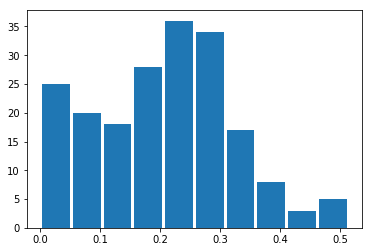

In [43]:
#TNG barred galaxies matched Illustris-1 unbarred disk galaxies
#Gas Fraction
tng_M_barID = []
il1_M_nobar_diskID = []
for i in tng_bar_matched_il1_nobardisk.keys():
    tng_M_barID.append(i)
    il1_M_nobar_diskID.append(tng_bar_matched_il1_nobardisk[i])
    
tng_barGasF = tng_GasFraction[tng_M_barID]
il1_unbarGasF = il1_GasFraction[il1_M_nobar_diskID]

n_il1, bins, o = plt.hist(il1_unbarGasF, rwidth=0.9)
n_tng = HistValAndBin(tng_barGasF, bins)

np.sum(n_il1), np.sum(n_tng)

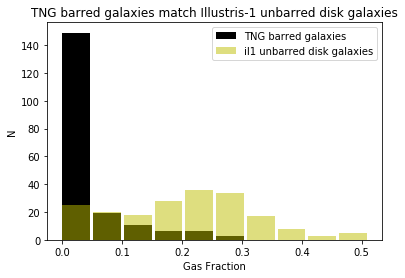

In [38]:
#Plot Gas Histogram
plt.bar(bins[:-1], n_tng, width=(bins[1] - bins[0])*0.9, align = 'edge',color='black', label='TNG barred galaxies')
plt.bar(bins[:-1], n_il1, width=(bins[1] - bins[0])*0.9, align = 'edge', alpha=0.5,color='y', label='il1 unbarred disk galaxies')
plt.title('TNG barred galaxies match Illustris-1 unbarred disk galaxies')
plt.xlabel('Gas Fraction')
plt.ylabel('N')
plt.legend()
#plt.savefig('f:/Linux/local_result/GasFraction_TNG_barred_il1_unbardisk.png',dpi=300)

In [8]:
#Stellar Mass
tng_barSM = np.log10(tng_StellarMass[tng_M_barID] * 10**10)
il1_unbarSM = np.log10(il1_StellarMass[il1_M_nobar_diskID] * 10**10)

SM_bins = np.arange(10, 13.5, 0.25)
SM_tng = HistValAndBin(tng_barSM, SM_bins)
SM_il1 = HistValAndBin(il1_unbarSM, SM_bins)
SM_tng,SM_il1

([45, 97, 26, 10, 5, 1, 1, 1, 0, 0, 0, 0, 0],
 [59, 67, 40, 9, 7, 2, 2, 0, 0, 0, 0, 0, 0])

In [35]:
#check tng barred galaxies stellar particlses
tng_Stellar = il.func.loadSubhalos('TNG', 99, 'SubhaloLenType')[:,4]
smallhaloID = []
for i in tng_M_barID:
    if tng_Stellar[i] < 40000:
        smallhaloID.append(i)


tng_M_barID_big = []
il1_M_nobar_diskID_big = []
for i in tng_M_barID:
    if i not in smallhaloID:
        tng_M_barID_big.append(i)
        il1_M_nobar_diskID_big.append(tng_bar_matched_il1_nobardisk[i])
len(smallhaloID), len(tng_M_barID_big) , len(tng_M_barID), len(il1_M_nobar_diskID_big)

(14, 180, 194, 180)

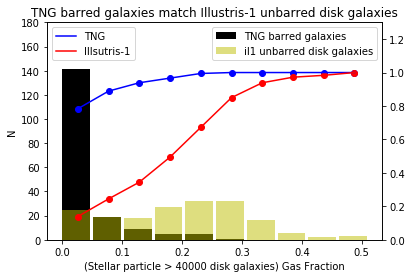

In [60]:
tng_barGasF_big = tng_GasFraction[tng_M_barID_big]
il1_unbarGasF_big = il1_GasFraction[il1_M_nobar_diskID_big]

n_il1_big = HistValAndBin(il1_unbarGasF_big, bins)
n_tng_big = HistValAndBin(tng_barGasF_big, bins)

tng_frac = n_tng_big / np.sum(n_tng_big)
il1_frac = n_il1_big / np.sum(n_il1_big)

for i in range(1, len(tng_frac)):
    tng_frac[i] += tng_frac[i-1]
    il1_frac[i] += il1_frac[i-1]

#Plot Gas Histogram
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.bar(bins[:-1], n_tng_big, width=(bins[1] - bins[0])*0.9, align = 'edge',color='black', label='TNG barred galaxies')
ax1.bar(bins[:-1], n_il1_big, width=(bins[1] - bins[0])*0.9, align = 'edge', alpha=0.5,color='y', label='il1 unbarred disk galaxies')
ax1.set_title('TNG barred galaxies match Illustris-1 unbarred disk galaxies')
ax1.set_xlabel('(Stellar particle > 40000 disk galaxies) Gas Fraction')
ax1.set_ylabel('N')
ax1.set_ylim(0,180)
ax1.legend()

p = (bins[1] - bins[0])*0.5
ax2.plot(bins[:-1] + p, tng_frac, label='TNG', color = 'b')
ax2.plot(bins[:-1] + p, il1_frac, label='Illsutris-1', color = 'r')
ax2.scatter(bins[:-1] + p, tng_frac, color='b')
ax2.scatter(bins[:-1] + p, il1_frac, color='r')
ax2.set_ylim(0,1.3)
ax2.legend(loc=2)
# plt.savefig('f:/Linux/local_result/GasFraction_TNG_barred_il1_unbardisk_40000.png',dpi=300)

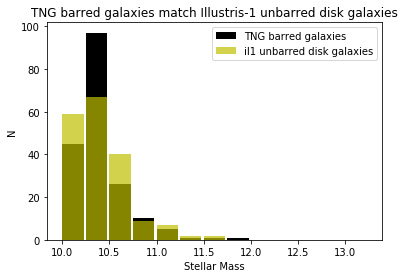

In [9]:
#Plot Stellar Mass Hist
plt.bar(SM_bins[:-1], SM_tng, width=(SM_bins[1] - SM_bins[0])*0.9, align = 'edge', color='k',label='TNG barred galaxies')
plt.bar(SM_bins[:-1], SM_il1, width=(SM_bins[1] - SM_bins[0])*0.9, align = 'edge', color='y', alpha = 0.7,label='il1 unbarred disk galaxies')
plt.title('TNG barred galaxies match Illustris-1 unbarred disk galaxies')
plt.xlabel('Stellar Mass')
plt.ylabel('N')
plt.legend()
#plt.savefig('f:/Linux/local_result/StellarMass_TNG_barred_il1_unbardisk.png',dpi=300)

(186.0, 185)

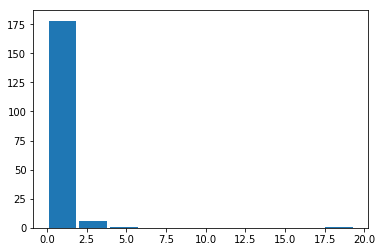

In [10]:
#SFR
tng_barSFR = tng_SFR[tng_M_barID]
il1_unbarSFR = il1_SFR[il1_M_nobar_diskID]


SFR_tng, SFR_bins, o = plt.hist(tng_barSFR, rwidth=0.9)
SFR_il1 = HistValAndBin(il1_unbarSFR, SFR_bins)
SFR_il1 = np.array(SFR_il1)
np.sum(SFR_tng), np.sum(SFR_il1)

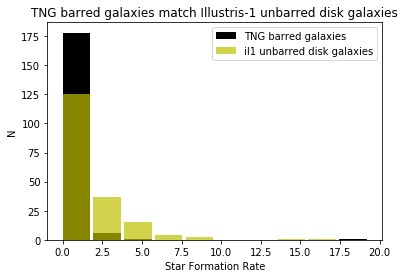

In [11]:
#Plot SFR Hist
plt.bar(SFR_bins[:-1], SFR_tng, width=(SFR_bins[1] - SFR_bins[0])*0.9, align = 'edge', color='k',label='TNG barred galaxies')
plt.bar(SFR_bins[:-1], SFR_il1, width=(SFR_bins[1] - SFR_bins[0])*0.9, align = 'edge', color='y', alpha = 0.7,label='il1 unbarred disk galaxies')
plt.title('TNG barred galaxies match Illustris-1 unbarred disk galaxies')
plt.xlabel('Star Formation Rate')
plt.ylabel('N')
plt.legend()
#plt.savefig('f:/Linux/local_result/SFR_TNG_barred_il1_unbardisk.png',dpi=300)

In [19]:
#TNG barred vs. Illustris-1 barred
tng_Matched_BID = []
il1_Matched_BID = []
for i in tng_bar_matched_il1bar.keys():
    tng_Matched_BID.append(i)
    il1_Matched_BID.append(tng_bar_matched_il1bar[i])

24

In [20]:
#GasFraction
tng_MB_GasF = tng_GasFraction[tng_Matched_BID]
il1_MB_GasF = il1_GasFraction[il1_Matched_BID]

tng_GF = HistValAndBin(tng_MB_GasF, bins)
il1_GF = HistValAndBin(il1_MB_GasF, bins)
np.sum(tng_GF), np.sum(il1_GF)

(24, 24)

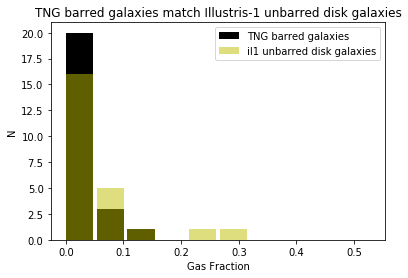

In [14]:
#Plot Gas Histogram
plt.bar(bins[:-1], tng_GF, width=(bins[1] - bins[0])*0.9, align = 'edge',color='black', label='TNG barred galaxies')
plt.bar(bins[:-1], il1_GF, width=(bins[1] - bins[0])*0.9, align = 'edge', alpha=0.5,color='y', label='il1 unbarred disk galaxies')
plt.title('TNG barred galaxies match Illustris-1 barred galaxies')
plt.xlabel('Gas Fraction')
plt.ylabel('N')
plt.legend()
#plt.savefig('f:/Linux/local_result/GasFraction_TNG_barred_il1_unbardisk.png',dpi=300)

In [18]:
#Stellar Mass
tng_M_barSM = np.log10(tng_StellarMass[tng_Matched_BID] * 10**10)
il1_M_barSM = np.log10(il1_StellarMass[il1_Matched_BID] * 10**10)

tng_M_SM = HistValAndBin(tng_M_barSM, SM_bins)
il1_M_SM = HistValAndBin(il1_M_barSM, SM_bins)
np.sum(tng_M_SM), np.sum(il1_M_SM), len(tng_Matched_BID)

(24, 24, 24)

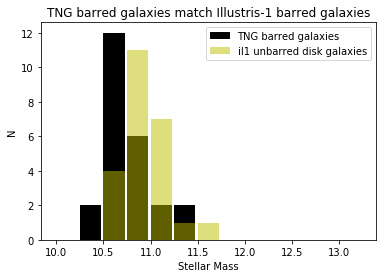

In [21]:
#Plot Stellar Mass Histogram
plt.bar(SM_bins[:-1], tng_M_SM, width=(SM_bins[1] - SM_bins[0])*0.9, align = 'edge',color='black', label='TNG barred galaxies')
plt.bar(SM_bins[:-1], il1_M_SM, width=(SM_bins[1] - SM_bins[0])*0.9, align = 'edge', alpha=0.5,color='y', label='il1 unbarred disk galaxies')
plt.title('TNG barred galaxies match Illustris-1 barred galaxies')
plt.xlabel('Stellar Mass')
plt.ylabel('N')
plt.legend()
#plt.savefig('f:/Linux/local_result/GasFraction_TNG_barred_il1_unbardisk.png',dpi=300)

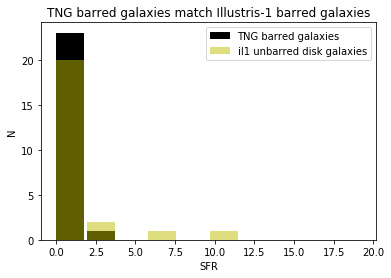

In [23]:
#SFR
tng_M_SFR = tng_SFR[tng_Matched_BID]
il1_M_SFR = il1_SFR[il1_Matched_BID]

tng_M_SFR = HistValAndBin(tng_M_SFR, SFR_bins)
il1_M_SFR = HistValAndBin(il1_M_SFR, SFR_bins)

#Plot Stellar Mass Histogram
plt.bar(SFR_bins[:-1], tng_M_SFR, width=(SFR_bins[1] - SFR_bins[0])*0.9, align = 'edge',color='black', label='TNG barred galaxies')
plt.bar(SFR_bins[:-1], il1_M_SFR, width=(SFR_bins[1] - SFR_bins[0])*0.9, align = 'edge', alpha=0.5,color='y', label='il1 unbarred disk galaxies')
plt.title('TNG barred galaxies match Illustris-1 barred galaxies')
plt.xlabel('SFR')
plt.ylabel('N')
plt.legend()

In [ ]:
#TNG disk galaxies matched Illustris-1 not disk galaxies
tng_matched_il1_nodiskID = []
il1_matched_nodiskID = []
for i in tng_matched_il1notdisk.keys():
    tng_matched_il1_nodiskID.append(i)
    il1_matched_nodiskID.append(tng_matched_il1notdisk[i])
tng_matched_nodisk_SM = tng_StellarMass[tng_matched_il1notdisk]
il1_matched_nodisk_SM = il1_StellarMass[]


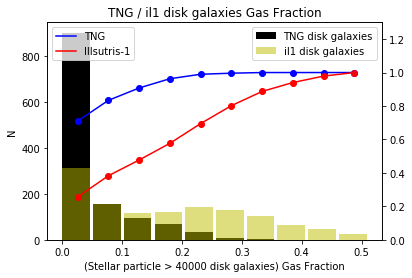

In [71]:
#TNG-il1 all disk galaxies gas fraction
big = []
for i in tngdisk:
    if tng_Stellar[i] > 40000:
        big.append(i)

tng_gas = tng_GasFraction[big]
il1_gas = il1_GasFraction[il1disk]

n_tng_disk = HistValAndBin(tng_gas, bins)
n_il1_disk = HistValAndBin(il1_gas, bins) 

tng_disk_frac = n_tng_disk / np.sum(n_tng_disk)
il1_disk_frac = n_il1_disk / np.sum(n_il1_disk)

for i in range(1, len(tng_frac)):
    tng_disk_frac[i] += tng_disk_frac[i-1]
    il1_disk_frac[i] += il1_disk_frac[i-1]

#Plot Gas Histogram
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.bar(bins[:-1], n_tng_disk, width=(bins[1] - bins[0])*0.9, align = 'edge',color='black', label='TNG disk galaxies')
ax1.bar(bins[:-1], n_il1_disk, width=(bins[1] - bins[0])*0.9, align = 'edge', alpha=0.5,color='y', label='il1 disk galaxies')
ax1.set_title('TNG / il1 disk galaxies Gas Fraction')
ax1.set_xlabel('(Stellar particle > 40000 disk galaxies) Gas Fraction')
ax1.set_ylabel('N')
# ax1.set_ylim(0,300)
ax1.legend()

p = (bins[1] - bins[0])*0.5
ax2.plot(bins[:-1] + p, tng_disk_frac, label='TNG', color = 'b')
ax2.plot(bins[:-1] + p, il1_disk_frac, label='Illsutris-1', color = 'r')
ax2.scatter(bins[:-1] + p, tng_disk_frac, color='b')
ax2.scatter(bins[:-1] + p, il1_disk_frac, color='r')
ax2.set_ylim(0,1.3)
ax2.legend(loc=2)
#plt.savefig('f:/Linux/local_result/TNG_il1_disk_galaxies_GasFraction.png',dpi=300)

In [2]:
#angular momentum
il1_stellarAng = np.load('f:/Linux/localRUN/il1_stellarAng.npy')
tng_stellarAng = np.load('f:/Linux/localRUN/tng_StellarAng.npy')

In [20]:
tng_Arg = []
for i in tng_barred:
    tng_Arg.append(np.where(tngdisk==i)[0][0])
    
tng_Arg = np.array(tng_Arg)

il1_Arg = []
for i in il1_barred:
    il1_Arg.append(np.where(il1disk==i)[0][0])
    
il1_Arg = np.array(il1_Arg)

In [29]:
il1_Jsp = il1_stellarAng / il1_StellarMass[il1disk, np.newaxis]
tng_Jsp = tng_stellarAng / tng_StellarMass[tngdisk, np.newaxis]

il1_barJsp = np.linalg.norm(il1_Jsp[il1_Arg], axis = 1)
tng_barJsp = np.linalg.norm(tng_Jsp[tng_Arg], axis = 1)

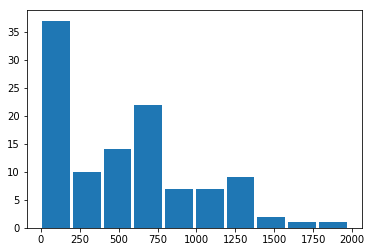

In [35]:
n, bins, o = plt.hist(il1_barJsp, 10, rwidth=0.9)

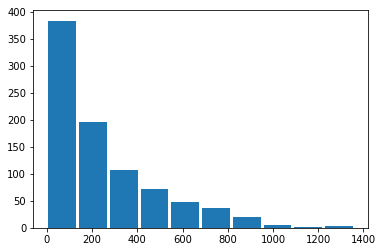

In [36]:
n, bins, o = plt.hist(tng_barJsp, 10, rwidth=0.9)